# MiCoGPT v2.0 Fine-tuning (Baseline: Only Species)

本 Notebook 演示如何加载 **Baseline 预训练模型** (仅使用物种序列，无 Value/Condition/Prior)，并在下游任务上进行微调。

**注意：**
由于 Baseline 模型在预训练时没有接触过 `value_ids` 和 `condition_ids`，我们在微调时也必须屏蔽这些输入，以免引入未训练的随机噪声。

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pickle import load as pkl_load
from argparse import Namespace
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from torch.utils.data import Subset
from transformers import Trainer, TrainingArguments
from transformers.trainer_callback import EarlyStoppingCallback

# --- v2.0 自定义模块 ---
from MiCoGPT.utils_vCross.model_vCross import MiCoGPTConfig, MiCoGPTForSequenceClassification
from MiCoGPT.utils_vCross.collator_vCross import MiCoGPTClassificationCollator

# --- 复用工具函数 ---
from MiCoGPT.utils.finetune import prepare_labels_for_subset, split_train_val_by_project_stratified_with_labels
from MiCoGPT.utils.finetune_v2 import SubsetWithLabels

import warnings
warnings.filterwarnings("ignore")

## 1. 配置参数 (Configuration)

In [2]:
args = Namespace(
    # 输入语料库
    input="../data/vCross/ResMicroDB_90338_vCross.pkl",
    
    # [Baseline] 预训练模型路径
    pretrained_model="../models/pretrain_vCross_baseline",
    
    # 输出目录
    # output="../models/finetuned_vCross_baseline",
    # log="../logs/finetuned_vCross_baseline",
    
    output="../models/finetuned_vCross_baseline_valLoss",
    log="../logs/finetuned_vCross_baseline_valLoss",
    
    # 任务相关
    label_col="Is_Healthy",
    split_group="A",
    val_ratio=0.2,
)

print("Args:", args)

Args: Namespace(input='../data/vCross/ResMicroDB_90338_vCross.pkl', pretrained_model='../models/pretrain_vCross_baseline', output='../models/finetuned_vCross_baseline_valLoss', log='../logs/finetuned_vCross_baseline_valLoss', label_col='Is_Healthy', split_group='A', val_ratio=0.2)


## 2. 加载语料库 (Load Corpus)

In [3]:
print(f"Loading corpus from {args.input} ...")
with open(args.input, "rb") as f:
    corpus = pkl_load(f)
    
print(f"Loaded corpus with {len(corpus)} samples.")

Loading corpus from ../data/vCross/ResMicroDB_90338_vCross.pkl ...
Loaded corpus with 90338 samples.


## 3. 数据准备 (Data Preparation)

In [4]:
# 1. 筛选子集
meta = corpus.metadata
valid_mask = (meta["Split_Group"] == args.split_group) & (meta[args.label_col].notna())
finetune_indices = np.where(valid_mask)[0]
finetune_subset = Subset(corpus, finetune_indices)

# 2. 生成标签
labels_tensor, all_labels_array, le, num_labels = prepare_labels_for_subset(
    all_corpus=corpus,
    subset=finetune_subset,
    label_col=args.label_col,
    verbose=True
)

# 3. 划分训练/验证集
train_subset, val_subset = split_train_val_by_project_stratified_with_labels(
    finetune_subset,
    label_col=args.label_col,
    val_ratio=args.val_ratio,
    project_col="Project_ID"
)

print(f"Train size: {len(train_subset)}")
print(f"Val size: {len(val_subset)}")

[labels] subset size=55575
[labels] num_labels=2
[labels] distribution:
0    31073
1    24502
Name: count, dtype: int64
[split] total_samples=55575, target_val~11115
[split] eligible_projects=251, eligible_samples=55398
[split] ineligible_projects=16, ineligible_samples=177
[split] label_dist (overall):
Is_Healthy
False    31073
True     24502
Name: count, dtype: int64
[split] actual_val=11115 (target~11115), train=44460
[split] label_dist (val):
Is_Healthy
False    6109
True     5006
Name: count, dtype: int64
Train size: 44460
Val size: 11115


In [5]:
def create_dataset_with_labels(subset, all_labels_array):
    indices = subset.indices
    subset_labels = torch.tensor(all_labels_array[indices], dtype=torch.long)
    return SubsetWithLabels(subset, subset_labels)

train_ds = create_dataset_with_labels(train_subset, all_labels_array)
val_ds = create_dataset_with_labels(val_subset, all_labels_array)

## 4. 加载模型 (Load Model)

In [6]:
config = MiCoGPTConfig.from_pretrained(args.pretrained_model)
config.num_labels = num_labels
print("Model Config:", config)

model = MiCoGPTForSequenceClassification.from_pretrained(
    args.pretrained_model,
    config=config,
    ignore_mismatched_sizes=True
)

Model Config: MiCoGPTConfig {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "MiCoGPTForCausalLM"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 2,
  "condition_vocab_sizes": [],
  "embd_pdrop": 0.1,
  "eos_token_id": 3,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 256,
  "n_head": 8,
  "n_inner": null,
  "n_layer": 8,
  "n_positions": 512,
  "num_bins": 52,
  "pad_token_id": 0,
  "prior_matrix_path": null,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.33.3",
  "use_cache": true,
  "vocab_size": 1121
}



Some weights of MiCoGPTForSequenceClassification were not initialized from the model checkpoint at ../models/pretrain_vCross_baseline and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 5. 自定义 Baseline Collator

**关键步骤**：Baseline 模型只使用了 Species Token。我们需要确保微调时，**屏蔽 `value_ids` 和 `condition_ids`**，否则模型会把随机初始化的 Embedding 加进去，破坏预训练的特征。

In [7]:
class BaselineClassificationCollator(MiCoGPTClassificationCollator):
    def __call__(self, examples):
        # 先调用父类处理 input_ids 和 labels
        batch = super().__call__(examples)
        
        # [Baseline Key] 强制将 value_ids 和 condition_ids 设为 None
        # 这样模型 forward 时就会跳过这些 Embedding 的加法
        batch["value_ids"] = None
        batch["condition_ids"] = None
        
        return batch

baseline_collator = BaselineClassificationCollator(corpus.tokenizer, max_length=512)

## 6. 训练 (Training)

In [8]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1}

In [9]:
training_args = TrainingArguments(
    output_dir=args.output,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir=args.log,
    logging_steps=50,
    dataloader_num_workers=0,
    report_to=["tensorboard"],
    
    # 显存优化 (防止 Evaluation OOM)
    # eval_accumulation_steps=60,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    # 使用 Baseline 专用 Collator
    data_collator=baseline_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

In [10]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.332200,0.311025,0.874854,0.874429
2,0.238000,0.237562,0.904723,0.904591
3,0.195100,0.204187,0.919208,0.919149
4,0.166900,0.184883,0.927935,0.927916
5,0.150100,0.171239,0.934773,0.934749
6,0.134700,0.163336,0.937382,0.937383
7,0.151100,0.155672,0.940171,0.940166
8,0.132200,0.151090,0.942690,0.942692
9,0.100200,0.148258,0.944399,0.944399
10,0.100200,0.143635,0.946379,0.946369


TrainOutput(global_step=38920, training_loss=0.10619741557711565, metrics={'train_runtime': 6510.6493, 'train_samples_per_second': 682.881, 'train_steps_per_second': 21.35, 'total_flos': 3.223303942569984e+16, 'train_loss': 0.10619741557711565, 'epoch': 28.0})

## 7. 保存与分析 (Save & Analyze)

In [ ]:
# 1. 保存模型
trainer.save_model(args.output)
corpus.tokenizer.save_pretrained(args.output)

# 保存 Label Encoder (关键)
import joblib
joblib.dump(le, f"{args.output}/label_encoder.joblib")
print(f"Model and LabelEncoder saved to {args.output}")

# 2. 导出日志
log_history = trainer.state.log_history
with open(f"{args.output}/training_logs.json", "w") as f:
    json.dump(log_history, f, indent=2)

# 3. 绘制曲线
train_steps = [x["step"] for x in log_history if "loss" in x]
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]
eval_f1 = [x["eval_f1"] for x in log_history if "eval_f1" in x]

plt.figure(figsize=(12, 5))

# Loss 曲线
plt.subplot(1, 2, 1)
if train_steps: plt.plot(train_steps, train_loss, label="Train Loss", alpha=0.6)
if eval_steps: plt.plot(eval_steps, eval_loss, label="Val Loss", marker="o")
plt.title("Loss Curve")
plt.legend()

# F1 曲线
plt.subplot(1, 2, 2)
if eval_steps and eval_f1: 
    plt.plot(eval_steps, eval_f1, label="Val F1", color="orange", marker="s")
plt.title("F1 Score Curve")
plt.legend()

plt.savefig(f"{args.output}/training_curve.png")
plt.show()

Model and LabelEncoder saved to ../models/finetuned_vCross_baseline


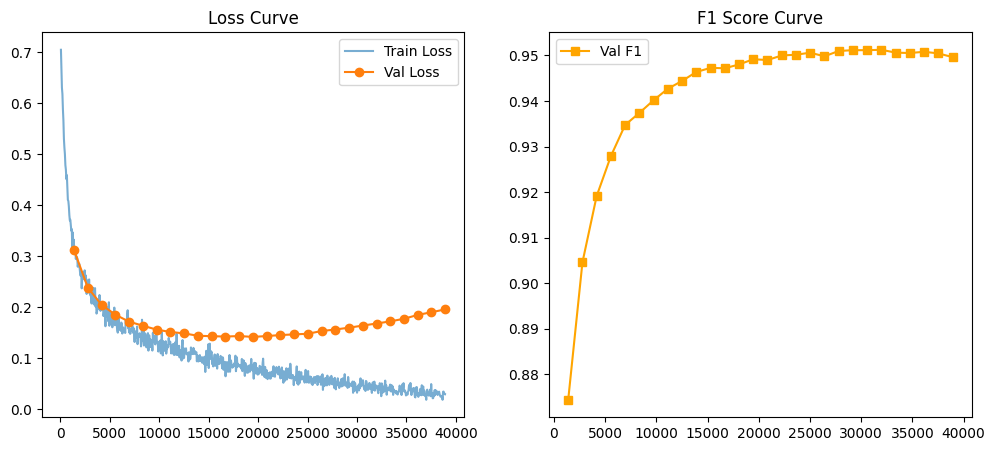

In [11]:
# 1. 保存模型
trainer.save_model(args.output)

# [Patch] Tokenizer 保存补丁
# 尝试使用标准 save_pretrained，如果报错(NotImplementedError)，则使用 joblib 备份
try:
    corpus.tokenizer.save_pretrained(args.output)
    print(f"Tokenizer saved to {args.output} via save_pretrained")
except NotImplementedError:
    import joblib
    print("Warning: Tokenizer.save_pretrained not implemented. Saving tokenizer object via joblib instead.")
    joblib.dump(corpus.tokenizer, f"{args.output}/tokenizer.joblib")
except Exception as e:
    # 兜底：任何其他错误也尝试用 joblib 救一下
    import joblib
    print(f"Warning: Failed to save tokenizer via save_pretrained ({e}). Saving via joblib.")
    joblib.dump(corpus.tokenizer, f"{args.output}/tokenizer.joblib")

# 保存 Label Encoder (关键)
import joblib
joblib.dump(le, f"{args.output}/label_encoder.joblib")
print(f"Model and LabelEncoder saved to {args.output}")

# 2. 导出日志
log_history = trainer.state.log_history
import json
with open(f"{args.output}/training_logs.json", "w") as f:
    json.dump(log_history, f, indent=2)

# 3. 绘制曲线
train_steps = [x["step"] for x in log_history if "loss" in x]
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]
eval_f1 = [x["eval_f1"] for x in log_history if "eval_f1" in x]

plt.figure(figsize=(12, 5))

# Loss 曲线
plt.subplot(1, 2, 1)
if train_steps: plt.plot(train_steps, train_loss, label="Train Loss", alpha=0.6)
if eval_steps: plt.plot(eval_steps, eval_loss, label="Val Loss", marker="o")
plt.title("Loss Curve")
plt.legend()

# F1 曲线
plt.subplot(1, 2, 2)
if eval_steps and eval_f1: 
    plt.plot(eval_steps, eval_f1, label="Val F1", color="orange", marker="s")
plt.title("F1 Score Curve")
plt.legend()

plt.savefig(f"{args.output}/training_curve.png")
plt.show()

## 8. 预测 (Prediction on Split B)

使用微调后的模型对测试集 (Split_Group='B') 进行预测，并调用 `eval_and_save` 计算多项指标。

In [4]:
# 0. (可选) 重新加载模型和配置 (如果内存已清空)
# 如果你刚运行完上面的训练代码，可以跳过此 Cell；
# 如果你是重新打开 Notebook，请运行此 Cell 来加载训练好的模型。

import joblib
from MiCoGPT.utils_vCross.model_vCross import MiCoGPTConfig, MiCoGPTForSequenceClassification

def create_dataset_with_labels(subset, all_labels_array):
    # subset.indices 是在 corpus 中的全局索引
    indices = subset.indices
    # 从全局 labels 数组中提取对应标签
    subset_labels = torch.tensor(all_labels_array[indices], dtype=torch.long)
    return SubsetWithLabels(subset, subset_labels)

# 检查变量是否存在，如果不存在则加载
if 'trainer' not in locals() or 'model' not in locals() or 'le' not in locals():
    print(f"Loading model from {args.output} ...")
    
    # 1. 加载 Label Encoder
    le_path = f"{args.output}/label_encoder.joblib"
    if os.path.exists(le_path):
        le = joblib.load(le_path)
        print("Label Encoder loaded.")
    else:
        raise FileNotFoundError(f"Label Encoder not found at {le_path}. Please run training first.")

    # 2. 加载模型
    # 注意：这里需要 num_labels，可以从 le 推断
    if hasattr(le, "classes_"):
        num_labels = len(le.classes_)
    else:
        num_labels = len(le.categories_[0])
        
    config = MiCoGPTConfig.from_pretrained(args.output)
    model = MiCoGPTForSequenceClassification.from_pretrained(args.output, config=config)
    
    # 3. 重新定义 Collator (Baseline: 屏蔽 Value/Condition)
    # 确保前面已经定义了 BaselineClassificationCollator 类
    if 'BaselineClassificationCollator' not in locals():
        class BaselineClassificationCollator(MiCoGPTClassificationCollator):
            def __call__(self, examples):
                batch = super().__call__(examples)
                batch["value_ids"] = None
                batch["condition_ids"] = None
                return batch

    # 假设 corpus 已加载 (如果没加载，需要用户运行前面的加载语料库 Cell)
    # 这里我们需要 tokenizer 来初始化 collator
    if 'corpus' in locals():
        tokenizer = corpus.tokenizer
    else:
        # 尝试从保存的模型目录加载 tokenizer
        from transformers import GPT2Tokenizer
        # 注意：MiCoGPT 使用的是自定义 Tokenizer，但 save_pretrained 会保存成 standard format
        # 如果不行，建议用户先运行加载语料库的 Cell
        print("Warning: corpus not in memory. Using tokenizer from saved model.")
        # 这里我们假设用户至少运行了前面的 import 和 corpus 加载
        # 如果没有，下面的 collator 初始化可能会失败
        raise ValueError("Please run the 'Load Corpus' cell above to load the tokenizer first.")
        
    baseline_collator = BaselineClassificationCollator(tokenizer)
    
    # 4. 重建 Trainer (仅用于预测)
    trainer = Trainer(
        model=model,
        args=TrainingArguments(output_dir=args.output, per_device_eval_batch_size=32),
        data_collator=baseline_collator
    )
    print("Model and Trainer restored.")
else:
    print("Model and Trainer already in memory. Skipping reload.")

Loading model from ../models/finetuned_vCross_baseline ...
Label Encoder loaded.
Model and Trainer restored.


In [5]:
from MiCoGPT.utils.mgm_utils import eval_and_save

# 1. 准备测试集 (Split_Group = B)
print("Preparing Test Set (Split_Group='B')...")
meta = corpus.metadata
test_mask = (meta["Split_Group"] == "B") & (meta[args.label_col].notna())
test_indices = np.where(test_mask)[0]
test_subset = Subset(corpus, test_indices)

print(f"Test subset size: {len(test_subset)}")

# 2. 生成测试集标签 (复用训练时的 Encoder)
# 注意：这里必须传入训练时 fit 好的 le (encoder)，以保证标签 ID 映射一致
test_labels_tensor, test_all_labels, _, _ = prepare_labels_for_subset(
    all_corpus=corpus,
    subset=test_subset,
    label_col=args.label_col,
    encoder=le, 
    verbose=True
)

# 3. 包装 Dataset
test_ds = create_dataset_with_labels(test_subset, test_all_labels)

# 4. 预测
print("Running prediction...")
# Trainer 会自动使用最佳模型 (load_best_model_at_end=True)
predictions = trainer.predict(test_ds)
y_score = predictions.predictions
y_true = predictions.label_ids

# 5. 评估并保存
# 获取类别名称
if hasattr(le, "categories_"):
    # OneHotEncoder
    label_names = list(le.categories_[0])
else:
    # LabelEncoder
    label_names = [str(c) for c in le.classes_]

save_dir = f"{args.output}/prediction_B"
os.makedirs(save_dir, exist_ok=True)

print(f"Saving results to {save_dir}...")
eval_and_save(
    y_score=y_score,
    y_true=y_true,
    label_names=label_names,
    save_dir=save_dir,
    activation="softmax" # 模型输出 logits，需要 softmax 归一化
)

Preparing Test Set (Split_Group='B')...
Test subset size: 13901
[labels] subset size=13901
[labels] num_labels=2
[labels] distribution:
0    7776
1    6125
Name: count, dtype: int64
Running prediction...


Saving results to ../models/finetuned_vCross_baseline/prediction_B...
Evaluating biome source: False
         TN    FP    FN    TP     Acc      Sn      Sp     TPR     FPR      Rc  \
t                                                                               
0.000     0  6125     0  7776  0.5594  1.0000  0.0000  1.0000  1.0000  1.0000   
0.001   140  5985    39  7737  0.5666  0.9950  0.0229  0.9950  0.9771  0.9950   
0.002   191  5934    60  7716  0.5688  0.9923  0.0312  0.9923  0.9688  0.9923   
0.003   250  5875    70  7706  0.5723  0.9910  0.0408  0.9910  0.9592  0.9910   
0.004   276  5849    80  7696  0.5735  0.9897  0.0451  0.9897  0.9549  0.9897   
...     ...   ...   ...   ...     ...     ...     ...     ...     ...     ...   
0.997  3622  2503  1957  5819  0.6792  0.7483  0.5913  0.7483  0.4087  0.7483   
0.998  3812  2313  2136  5640  0.6800  0.7253  0.6224  0.7253  0.3776  0.7253   
0.999  4171  1954  2500  5276  0.6796  0.6785  0.6810  0.6785  0.3190  0.6785   
1.000  6

,Acc,Sn,Sp,TPR,FPR,Rc,Pr,F1,F-max,ROC-AUC,PR-AUC
0,0.5000,1.0000,0.0000,1.0000,1.0000,1.0000,0.5000,0.6646,0.697,0.7047,0.5534
1,0.6231,0.8380,0.3507,0.8380,0.6493,0.8380,0.5945,0.6859,0.697,0.7047,0.5534
2,0.6244,0.8074,0.3782,0.8074,0.6218,0.8074,0.6031,0.6758,0.697,0.7047,0.5534
3,0.6258,0.7912,0.3945,0.7912,0.6054,0.7912,0.6083,0.6702,0.697,0.7047,0.5534
4,0.6260,0.7794,0.4049,0.7794,0.5951,0.7794,0.6120,0.6656,0.697,0.7047,0.5534
...,...,...,...,...,...,...,...,...,...,...,...
997,0.6258,0.3945,0.7912,0.3945,0.2088,0.3945,0.7402,0.4002,0.697,0.7047,0.5534
998,0.6244,0.3782,0.8074,0.3782,0.1926,0.3782,0.7351,0.3885,0.697,0.7047,0.5534
999,0.6231,0.3507,0.8380,0.3507,0.1620,0.3507,0.7559,0.3738,0.697,0.7047,0.5534
1000,0.5000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,NaN,0.697,0.7047,0.5534


In [4]:
# 0. (可选) 重新加载模型和配置 (如果内存已清空)
# 如果你刚运行完上面的训练代码，可以跳过此 Cell；
# 如果你是重新打开 Notebook，请运行此 Cell 来加载训练好的模型。

import joblib
from MiCoGPT.utils_vCross.model_vCross import MiCoGPTConfig, MiCoGPTForSequenceClassification

def create_dataset_with_labels(subset, all_labels_array):
    # subset.indices 是在 corpus 中的全局索引
    indices = subset.indices
    # 从全局 labels 数组中提取对应标签
    subset_labels = torch.tensor(all_labels_array[indices], dtype=torch.long)
    return SubsetWithLabels(subset, subset_labels)

# 检查变量是否存在，如果不存在则加载
if 'trainer' not in locals() or 'model' not in locals() or 'le' not in locals():
    print(f"Loading model from {args.output} ...")
    
    # 1. 加载 Label Encoder
    le_path = f"{args.output}/label_encoder.joblib"
    if os.path.exists(le_path):
        le = joblib.load(le_path)
        print("Label Encoder loaded.")
    else:
        raise FileNotFoundError(f"Label Encoder not found at {le_path}. Please run training first.")

    # 2. 加载模型
    # 注意：这里需要 num_labels，可以从 le 推断
    if hasattr(le, "classes_"):
        num_labels = len(le.classes_)
    else:
        num_labels = len(le.categories_[0])
        
    config = MiCoGPTConfig.from_pretrained(args.output)
    model = MiCoGPTForSequenceClassification.from_pretrained(args.output, config=config)
    
    # 3. 重新定义 Collator (Baseline: 屏蔽 Value/Condition)
    # 确保前面已经定义了 BaselineClassificationCollator 类
    if 'BaselineClassificationCollator' not in locals():
        class BaselineClassificationCollator(MiCoGPTClassificationCollator):
            def __call__(self, examples):
                batch = super().__call__(examples)
                batch["value_ids"] = None
                batch["condition_ids"] = None
                return batch

    # 假设 corpus 已加载 (如果没加载，需要用户运行前面的加载语料库 Cell)
    # 这里我们需要 tokenizer 来初始化 collator
    if 'corpus' in locals():
        tokenizer = corpus.tokenizer
    else:
        # 尝试从保存的模型目录加载 tokenizer
        from transformers import GPT2Tokenizer
        # 注意：MiCoGPT 使用的是自定义 Tokenizer，但 save_pretrained 会保存成 standard format
        # 如果不行，建议用户先运行加载语料库的 Cell
        print("Warning: corpus not in memory. Using tokenizer from saved model.")
        # 这里我们假设用户至少运行了前面的 import 和 corpus 加载
        # 如果没有，下面的 collator 初始化可能会失败
        raise ValueError("Please run the 'Load Corpus' cell above to load the tokenizer first.")
        
    baseline_collator = BaselineClassificationCollator(tokenizer)
    
    # 4. 重建 Trainer (仅用于预测)
    trainer = Trainer(
        model=model,
        args=TrainingArguments(output_dir=args.output, per_device_eval_batch_size=32),
        data_collator=baseline_collator
    )
    print("Model and Trainer restored.")
else:
    print("Model and Trainer already in memory. Skipping reload.")

Loading model from ../models/finetuned_vCross_baseline_valLoss ...
Label Encoder loaded.
Model and Trainer restored.


In [5]:
from MiCoGPT.utils.mgm_utils import eval_and_save

# 1. 准备测试集 (Split_Group = B)
print("Preparing Test Set (Split_Group='B')...")
meta = corpus.metadata
test_mask = (meta["Split_Group"] == "B") & (meta[args.label_col].notna())
test_indices = np.where(test_mask)[0]
test_subset = Subset(corpus, test_indices)

print(f"Test subset size: {len(test_subset)}")

# 2. 生成测试集标签 (复用训练时的 Encoder)
# 注意：这里必须传入训练时 fit 好的 le (encoder)，以保证标签 ID 映射一致
test_labels_tensor, test_all_labels, _, _ = prepare_labels_for_subset(
    all_corpus=corpus,
    subset=test_subset,
    label_col=args.label_col,
    encoder=le, 
    verbose=True
)

# 3. 包装 Dataset
test_ds = create_dataset_with_labels(test_subset, test_all_labels)

# 4. 预测
print("Running prediction...")
# Trainer 会自动使用最佳模型 (load_best_model_at_end=True)
predictions = trainer.predict(test_ds)
y_score = predictions.predictions
y_true = predictions.label_ids

# 5. 评估并保存
# 获取类别名称
if hasattr(le, "categories_"):
    # OneHotEncoder
    label_names = list(le.categories_[0])
else:
    # LabelEncoder
    label_names = [str(c) for c in le.classes_]

save_dir = f"{args.output}/prediction_B"
os.makedirs(save_dir, exist_ok=True)

print(f"Saving results to {save_dir}...")
eval_and_save(
    y_score=y_score,
    y_true=y_true,
    label_names=label_names,
    save_dir=save_dir,
    activation="softmax" # 模型输出 logits，需要 softmax 归一化
)

Preparing Test Set (Split_Group='B')...
Test subset size: 13901
[labels] subset size=13901
[labels] num_labels=2
[labels] distribution:
0    7776
1    6125
Name: count, dtype: int64
Running prediction...


Saving results to ../models/finetuned_vCross_baseline_valLoss/prediction_B...
Evaluating biome source: False
         TN    FP    FN    TP     Acc      Sn      Sp     TPR     FPR      Rc  \
t                                                                               
0.000     0  6125     0  7776  0.5594  1.0000  0.0000  1.0000  1.0000  1.0000   
0.001    12  6113     3  7773  0.5600  0.9996  0.0020  0.9996  0.9980  0.9996   
0.002    25  6100     9  7767  0.5605  0.9988  0.0041  0.9988  0.9959  0.9988   
0.003    36  6089    12  7764  0.5611  0.9985  0.0059  0.9985  0.9941  0.9985   
0.004    49  6076    19  7757  0.5615  0.9976  0.0080  0.9976  0.9920  0.9976   
...     ...   ...   ...   ...     ...     ...     ...     ...     ...     ...   
0.997  4978  1147  3287  4489  0.6810  0.5773  0.8127  0.5773  0.1873  0.5773   
0.998  5243   882  3679  4097  0.6719  0.5269  0.8560  0.5269  0.1440  0.5269   
0.999  5602   523  4527  3249  0.6367  0.4178  0.9146  0.4178  0.0854  0.4178   


,Acc,Sn,Sp,TPR,FPR,Rc,Pr,F1,F-max,ROC-AUC,PR-AUC
0,0.5000,1.0000,0.0000,1.0000,1.0000,1.0000,0.5000,0.6646,0.7195,0.7527,0.637
1,0.5984,0.9571,0.2099,0.9571,0.7901,0.9571,0.5564,0.7035,0.7195,0.7527,0.637
2,0.6162,0.9274,0.2655,0.9274,0.7345,0.9274,0.5738,0.7073,0.7195,0.7527,0.637
3,0.6211,0.9056,0.2916,0.9056,0.7084,0.9056,0.5814,0.7049,0.7195,0.7527,0.637
4,0.6230,0.8874,0.3098,0.8874,0.6902,0.8874,0.5863,0.7013,0.7195,0.7527,0.637
...,...,...,...,...,...,...,...,...,...,...,...
997,0.6211,0.2916,0.9056,0.2916,0.0944,0.2916,0.7732,0.3406,0.7195,0.7527,0.637
998,0.6162,0.2655,0.9274,0.2655,0.0726,0.2655,0.7791,0.3252,0.7195,0.7527,0.637
999,0.5984,0.2099,0.9571,0.2099,0.0429,0.2099,0.8306,0.2833,0.7195,0.7527,0.637
1000,0.5000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,NaN,0.7195,0.7527,0.637
